## Econometric estimation of an IRL-based market portfolio model. Part II: QED

Welcome to your final course project on Advanced Topic RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns (the "QED" model) that is obtained by a generalization of   a model that you analyzed in the previous course
- Respectively, you are expected to re-utilize parts of your previous code from the course project from Course 3: RL (but you can also start from scratch - the template provided here is nearly identical to the one offered to you in course 3)
- Investige the role of non-linearities in price dynamics
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
 

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Estimate the model using the DJI portfolio of 30 stocks, first without signals, and then using simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Explore the implications of calibrated model parameters for default probabilities of stocks in your portfolio. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Experiment with other signals and investigate the impact on model calibration obtained with alternative signals. Present your conclusions and observations. (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis.
For example, you can repeat your analysis for the S&P portfolio.
Or maybe you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. Or anything else.  (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your second IRL based model of market dynamics.
- Develop intuition and understanding about the role of non-linearities in dynamics model. 
- Develop intuition on whether the same model could be calibrated to both equity and credit data.
- Be able to implement trading strategies based on this method.

Let's get started!

## The "Quantum Equlibrium-Disequlibrium" (QED) IRL-based model of stock returns

In Week 3 lectures of our course we presented the "QED" model
$$
d X_t = \kappa X_t  \left( \frac{\theta}{\kappa} - X_t - \frac{g}{\kappa} X_t^2 \right) dt +  X_t \left( {\bf w} {\bf z}_t \, dt + \sigma d W_t \right)
$$

In this project, you will explore calibration of this model to market data.
As in the course project for course 3 you analyzed the same model in the limit $ g = 0 $, you would be able to re-utilize parts of your previous code in this project).


In [8]:
import pandas as pd
import numpy as np


import scipy.optimize as optimize


import scipy as sci

import matplotlib.pyplot as plt
from datetime import datetime

In [6]:
# read the data to a Dataframe
import os
os.getcwd()
df_cap = pd.read_csv('data/dja_cap.csv')


In [9]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)


df_cap.head()



,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [7]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
#short_rolling.head(20)

In [ ]:
#moving average
short_rolling.head(20)

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.907097e+11,4.969299e+10,4.378631e+10,3.786435e+10,1.413180e+11,1.598955e+11,6.052901e+10,3.497057e+10,1.733199e+11,8.830129e+10,...,2.581162e+10,1.525788e+11,1.779570e+11,2.666573e+10,3.777601e+10,6.701154e+10,4.074611e+10,9.075302e+10,2.058484e+11,3.296335e+11


In [11]:
# Calculating the long-window (30 days) simple moving average

window_2 = 90
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

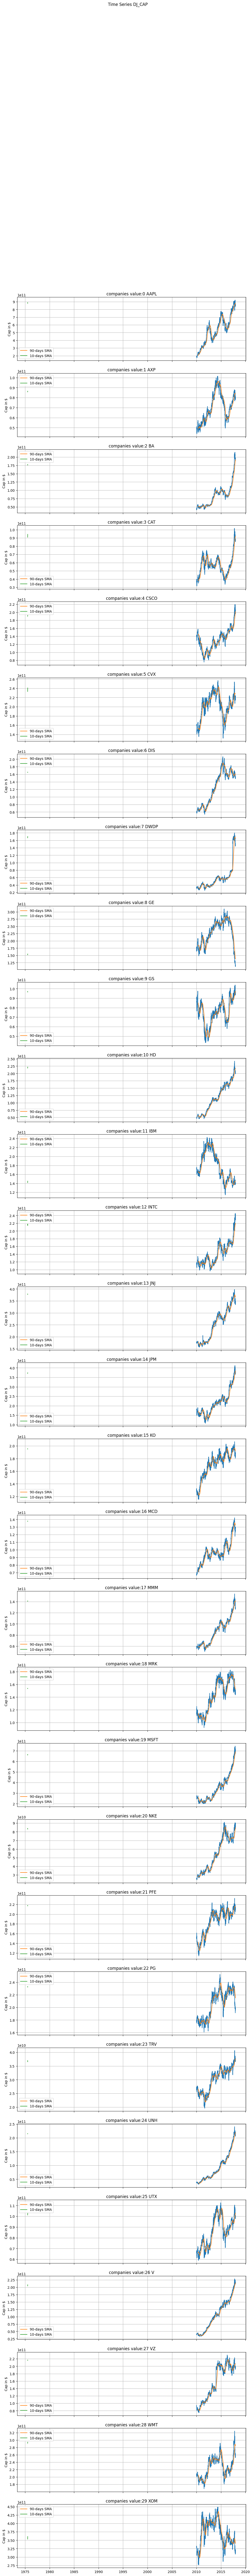

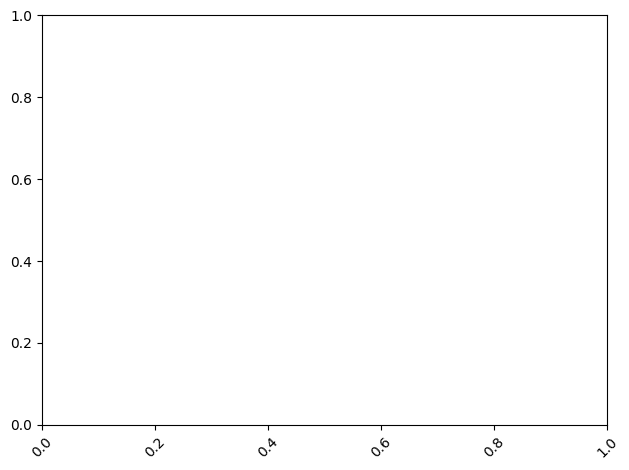

In [12]:

start_date = '2010-01-04'
end_date = '2017-12-31'
# Create subplots
n_series = len(df_cap.columns)
fig, axes = plt.subplots(n_series, 1, figsize=(12, 4*n_series), sharex=True)
fig.suptitle('Time Series DJ_CAP', fontsize=12)

# Plot each time series in its own subplot
for i, column in enumerate(df_cap.columns):
    axes[i].plot(df_cap.index, df_cap[column])
    axes[i].plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, column], 
          label = '%d-days SMA' % window_2)
    axes[i].plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, column], 
         label = '%d-days SMA' % window_1)
    


    axes[i].set_title(f'companies value:{i} {column}')
    axes[i].set_ylabel('Value')
    axes[i].legend(loc='best')
    axes[i].set_ylabel('Cap in $')
    axes[i].grid(True)

    

plt.show()

# Adjust x-axis labels on the bottom subplot
axes[-1].set_xlabel('Date')
plt.xticks(rotation=45)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


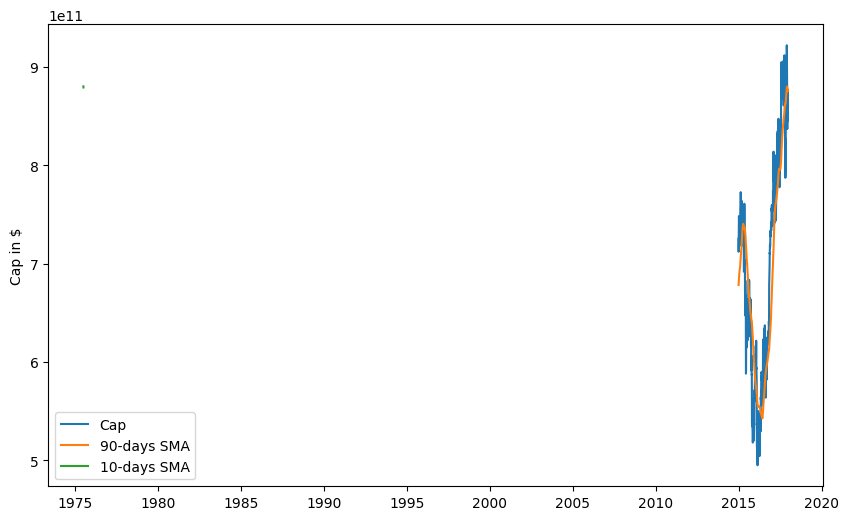

In [ ]:
ticker = 'VZ'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with or without moving average signals (Max 10 points)

To calibrate the model, it is convenient to use the log-prices instead of prices. Diffusion in the log-space 
$ y = \log x $ is given by the following Langevin equation:

$$
d y_t = - \frac{ \partial V(y)}{\partial y} dt + \sigma dW_t , \; \; \;  V(y)  \equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right) y  + \kappa e^y + \frac{1}{2} g e^{2y}
$$

where $ W_t $ is a standard Brownian motion.
In terms of variables $ y = \log x $, the negative log-likelihood of data is therefore

$$
LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ 2 \pi  \sigma^2}  } 
\exp \left\{  - \frac{1}{2 \sigma^2} \left(   \frac{ y_{t+ \Delta t} -   y_{t}}{ \Delta t} +  \frac{ \partial V(y)}{\partial y}   
\right)^2
\right\} , 
$$ 

where $ {\bf y}_t  = \log x_t $  now stands for observed values of log-cap. Note that because the model is Markov, the product over $ t = 0, \ldots, T-1 $ does not 
necessarily mean a product of transitions along the same trajectory. The negative log-likelihood should be minimized to estimate parameters $ 
\theta $, $ \sigma $, $ \kappa $, $ g $ and  $ {\bf w} $. You can try to estimate the model first without signals, then with signals.


In [85]:

class Langevin:
    '''
    Langevin equation
    y: np float vector size:( 1,n ): and log xt where xt is the market value
    Theta: float parameter is theta
    sigma: float parameter the volatility
    w : np float vector size:( n, 1) :is the weight to be calibrated to the predictor Zt
    Zt: np float vector size:( 1,n )input computed designed as Predictor

    #check criterion
    Theta > -kappa^2/(4.0*g)

    '''
    def __init__(self, y=np.ones(5), Theta=3, sigma=0.1, kappa=0.0011, g=-2, w=None, Zt=None):
        self.y = y
        self.Theta = Theta
        self.sigma = sigma
        self.kappa = kappa
        self.g = g
        self.w = w if w is not None else np.ones(len(y))
        self.Zt = Zt if Zt is not None else np.ones(len(y))

    @staticmethod
    def _V(y, Theta, sigma, kappa, g, w, Zt):
        return -(Theta - 0.5 * sigma * sigma + np.dot(w, Zt)) * y + kappa * np.exp(y) + 0.5 * g * np.exp(2.0 * y)

  

    @staticmethod
    def _DV_y(y, Theta, sigma, kappa, g, w, Zt):
        return -(Theta - 0.5 * sigma * sigma + np.dot(w, Zt)) + kappa * np.exp(y) + g * np.exp(2 * y)


    @staticmethod
    def _D2V_y2(y,  kappa, g):
        return kappa * np.exp(y) + 2 * g * np.exp(2 * y)
    
    @staticmethod
    def _kramers_function(y, a, b, Theta, sigma, kappa, g, w, Zt):
        # Calculate the potential V(y)
        V = -(Theta - 0.5 * sigma * sigma + np.dot(w, Zt)) * y + kappa * np.exp(y) + 0.5 * g * np.exp(2.0 * y)
        
        # Calculate V(a) and V(b)
        V_a = -(Theta - 0.5 * sigma * sigma + np.dot(w, Zt)) * a + kappa * np.exp(a) + 0.5 * g * np.exp(2.0 * a)
        V_b = -(Theta - 0.5 * sigma * sigma + np.dot(w, Zt)) * b + kappa * np.exp(b) + 0.5 * g * np.exp(2.0 * b)
        
        # Calculate the Kramers function
        kramers = np.sqrt(abs(V_b - V_a) / (2 * np.pi)) * np.exp(-(V - V_a) / (sigma**2))
        
        return kramers

    def kramers_function(self, a, b):
        '''
        Calculate the Kramers function for given parameters a and b
        '''
        return self._kramers_function(self.y, a, b, self.Theta, self.sigma, self.kappa, self.g, self.w, self.Zt)
    @classmethod
    def _LLm(cls, y, Theta, sigma, kappa, g, w, Zt, dt=1.0/252):
        resDV_y = cls._DV_y(y, Theta, sigma, kappa, g, w, Zt)
        resydt1 = np.diff(y, prepend=0) / dt
        sumresydt1resDV_y = resydt1 + resDV_y
        res = np.power(sumresydt1resDV_y, 2)
        res /= 2 * sigma * sigma
        res = np.exp(-res)
        res /= np.sqrt(2 * np.pi * np.power(sigma, 2))
        return -np.sum(np.log(res))  # Return negative log-likelihood
    
    @classmethod
    def _kramers_function(cls, a, b, Theta, sigma, kappa, g, w, Zt):
    
        
        # Calculate V(a) and V(b)
        
        V_a=cls._V(a, Theta, sigma, kappa, g, w, Zt)
        V_b=cls._V(b, Theta, sigma, kappa, g, w, Zt)

        #calculate second derivate V2(a) and V2(b)
        
        V2_a=cls._D2V_y2(a, kappa, g)
        V2_b=cls._D2V_y2(b, kappa, g)
        
     
        # Calculate the Kramers function
        kramers = np.sqrt(np.absolute(V2_a)*np.absolute(V2_b)) / (2 * np.pi) * np.exp(-2*(V_a - V_b) / (sigma**2))

    def V(self):
        '''
        return V as Vector
        '''
        return self._V(self.y, self.Theta, self.sigma, self.kappa, self.g, self.w, self.Zt)

    def DV_y(self):
        '''
        return Dy_y
        '''
        return self._DV_y(self.y, self.Theta, self.sigma, self.kappa, self.g, self.w, self.Zt)
    
    def D2V_y2(self):
        '''
        return D2V_y2 (second derivative of V with respect to y)
        '''
        return self._D2V_y2(self.y, self.kappa, self.g)

    def LLm(self, dt=1.0/252):
        '''
        return LLM based on the expression above
        '''
        return self._LLm(self.y, self.Theta, self.sigma, self.kappa, self.g, self.w, self.Zt, dt)

    def min(self):
         #check criterion
         #Theta > -kappa^2/(4.0*g)
        initial_guess = [90, 0.005, -4.15846880e+01,4, 0]
        bounds = [(-100, 1000), (0, 0.05), (-100, 100), (0, 100), (-10, 10)]

        def objective(x):
            return self._LLm(self.y, x[0], x[1], x[2], x[3], x[4], self.Zt, dt=1.0/252)
        



        def constraint(x):
            theta, _, kappa, g, _ = x
            return theta + kappa**2 / (4.0 * g)  # This should be > 0

        constraints = [{'type': 'ineq', 'fun': constraint}]

        result = optimize.minimize(
            objective, 
            initial_guess, 
            method='SLSQP',
            bounds=bounds,
            #constraints=constraints,
            options={'maxiter': 10000, 'ftol': 1e-6, 'disp': True}
        )

        if result.success:
            fitted_params = result.x
            print("Fitted parameters:", fitted_params)
            print("Final negative log-likelihood:", result.fun)
            print("Constraint satisfaction:", constraint(fitted_params))
            self.Theta=result.x[0]
            self.sigma=result.x[1]
            self.kappa=result.x[2]
            self.g=result.x[3]
            self.w=result.x[4]
            return fitted_params
        else:
            raise ValueError(f"Optimization failed: {result.message}")




    def kramers_function(self, a, b):
        '''
        Calculate the Kramers function for given parameters a and b
        '''
        return self._kramers_function( a, b, self.Theta, self.sigma, self.kappa, self.g, self.w, self.Zt)


In [86]:
lenght=100
y=df_cap.loc[start_date:end_date, 'AAPL'].tail(lenght)

window_1 = 30
window_2 = 90
long_rolling = df_cap.rolling(window=window_2).mean()
short_rolling = df_cap.rolling(window=window_1).mean()

Zt=long_rolling-short_rolling
Zt=Zt.tail(lenght)


L=len(y)

#print(L)

#print(np.log(y))
lang=Langevin(y=np.log(y), kappa=+0.001, w=1.0, g=-2)
#plt.plot(lang.V())
#plt.show()
lang.min() 


/home/faridb/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib64/python3.12/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Inequality constraints incompatible    (Exit mode 4)
            Current function value: inf
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1


ValueError: Optimization failed: Inequality constraints incompatible

In [76]:
lang.Theta


0.0

## Part 2: Analysis of default rates  (Max 10 point)

For a particle in a potential $ V(y) $ with a metastable minimum $ y = a $ and a barrier with a peak located at $ y = b $, the famous Kramers' escape formula gives the following expression for the escape rate $ r $ (see e.g. the book by van Kampen):

$$ 
r = \frac{\sqrt{ V''(a) \left| V''(b) \right| }}{2 \pi} \exp \left[ - \frac{2}{\sigma^2} (V(b) - V(a) ) \right]
$$

Here $ V''(a) $ and $ V''(b) $ stand for the second derivatives of the potential $ V(y) $ at the minimum and the maximum, respectively. This formula applies as long as the barrier height $ \Delta E \equiv  (V(b) - V(a) \gg \frac{\sigma^2}{2} $. 

Apply the Kramers formula to the QED potential and parameters that you found in your calibration. What range of values of $ r $ do you obtain? Do these values make sense to you? Can you think how you could use the Kramers relation as a way to regularize your MLE calibration?



In [70]:
print(lang.kramers_function(-5,2))


None



###Visulazation of V function

###Plotting V function in order to visualize a and b points 

Then we implement r value by implementing the function above

We assume the following  value for the params obtained by calibration process 







In [ ]:
# select of the interval
x = np.linspace(-0.6,3.7,100)

# set paramter found from calibration no signal

       #condition Theta > -kappa^2/(4*g) s
  

Theta =-8.68795828e+01
sigma=1.01326968e-03
kappa= -50 ##-4.00456179e+00
g= 1.99463314e+00
w=0.0 ##-8.84128316e-02
Zt=0.0 # we restrain the calibration to the first 100 value to reduce the calibration process time

#V(x,Theta,sigma, kappa, g,w,Zt)

True


In [ ]:
##a potential barrier between the local minimum and an essential singularity at zero can be observed


##question: What range of values of r do you obtain? 

##Answer: Delta E should be equal on the volatility which seems not to be the case here
##Kramer factor should reproduce a probability of default (Value between 0 at 1) with should be quite small here  given the comanies analysed





###Do these values make sense to you? 
##Can you think how you could use the Kramers relation as a way to regularize your MLE calibration?
##Answer: integrated constraints on the hessian matrix as stated might be able to obtain better calibrationfigures
##another test would be to compare this probality with the cDS value of those companies (assuming rate of recovery can be easily extracted here)


## Part 3: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


## answer

#A signal that could be interesting to test would be to analyse the parameter values calibrated (over time : let say on a forthnighly basis) vs the paramters obtained for the Index itself.
the idea would be to consider if the relationship between then index and the indivual stocks can be subject to arbitrage (shorting stocks with highest Energy (vol)and long the ones with the lowest vol). This would be extremly relevant to extent the analysis to ETFS 

## Part 4 (Optional): Show me something else (Max 10 points).

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [ ]:
# Put the rest of your code and analysis for Part 3 here.

In [ ]:
#I was initialy thinking to use this model and compare two or more  distincts ETFs tracking the same underlying as the difference between NAV and premium can be significant temporarilly
# the assumption would be to consider the volume  traded as signal and assuming the paramter should identical.
# If volume create a distortion, this would be reflected on the price and then give an arbitrage opportunity


In [ ]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_DJI=np.sum(df_cap, axis=1)


df_DJI.head()

date
2010-01-04    3.465480e+12
2010-01-05    3.464521e+12
2010-01-06    3.457581e+12
2010-01-07    3.468896e+12
2010-01-08    3.474456e+12
dtype: float64

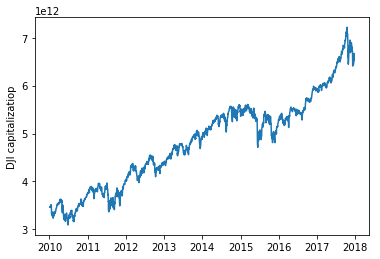

In [ ]:
plt.plot(df_DJI)
plt.ylabel('DJI capitalization: sum of the 30 stocks')
plt.show()

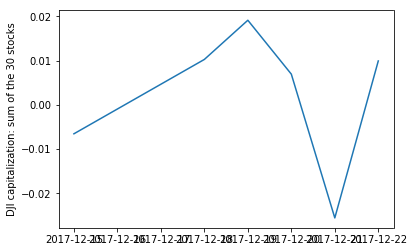

In [ ]:
Theta =-8.68795828e+01
sigma=1.01326968e-03
kappa= -50 ##-4.00456179e+00
g= 1.99463314e+00
w=0.0 ##-8.84128316e-02


Y=df_DJI.pct_change().tail(-1).tail(6)
Y=df_cap['AAPL'].pct_change().tail(-1).tail(6)
plt.plot(Y)
plt.ylabel('DJI capitalization: sum of the 30 stocks')
plt.show()


In [ ]:
LLm(Y,Theta,sigma, kappa, g,w,isZ=0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


array([ inf])